In [4]:
import numpy as np
import pandas as pd

In [7]:
clusters_df = pd.read_csv("../data/clusters0_df.csv")

In [9]:
clusters_df.drop(columns=['Unnamed: 0'], inplace=True)
clusters_df.rename(columns={"full_date": "date_time",
                  "pm": "value"}, inplace=True)

In [49]:
clusters_df['date_time'] = pd.to_datetime(clusters_df['date_time'], format='mixed')

In [81]:
clusters_df = clusters_df.dropna()

In [13]:
import math
from sklearn.base import BaseEstimator, TransformerMixin

# If you need holidays:
#   pip install holidays
import holidays

class DateTimeFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, country='KZ'):
        self.country = country
        self.holiday_calendar = holidays.CountryHoliday(self.country, years=[2017,2018,2019,2020])
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Ensure we have a datetime column
        X = X.copy()
        if not np.issubdtype(X['date_time'].dtype, np.datetime64):
            X['date_time'] = pd.to_datetime(X['date_time'])
        
        # Basic time features
        X['year'] = X['date_time'].dt.year
        X['month'] = X['date_time'].dt.month
        X['day_of_week'] = X['date_time'].dt.weekday  # Monday=0, Sunday=6
        X['day_of_year'] = X['date_time'].dt.dayofyear
        
        # Holiday feature
        X['is_holiday'] = X['date_time'].dt.date.astype(str).isin(self.holiday_calendar)
        X['is_holiday'] = X['is_holiday'].astype(int)
        
        # Trend (days from min date)
        diff = X['date_time'] - X['date_time'].min()
        X['trend'] = diff.dt.days
        
        # Example custom cyclical yearly features (like sin/cos with period=365)
        X['f1s'] = np.sin(X['trend'] * 2 * math.pi / 365)
        X['f1c'] = np.cos(X['trend'] * 2 * math.pi / 365)
        
        
        # More harmonic expansions if you want them
        X['f2s'] = np.sin(X['trend'] * 2 * math.pi / (365 * 2))
        X['f2c'] = np.cos(X['trend'] * 2 * math.pi / (365 * 2))
        # etc.

        # Drop original date_time if you don't need it
        
        return X


In [94]:
from sklearn.base import BaseEstimator, TransformerMixin

class LagRollingFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, lags=[1, 7], windows=[3, 7]):
        """
        lags: list of lag offsets, e.g., [1,7] means create value_lag1, value_lag7.
        windows: list of rolling windows in days, e.g., [3,7] means rolling_3_mean, rolling_3_std, etc.
        """
        self.lags = lags
        self.windows = windows

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        # Ensure data is sorted by date_time
        # if not X['date_time'].is_monotonic_increasing:
        #     X.sort_values('date_time', inplace=True)
        # Create lag features
        for lag in self.lags:
            X[f'value_lag{lag}'] = X['value'].shift(lag)

        # Create rolling statistics features
        for w in self.windows:
            shifted_series = X['value'].shift(1)  # Ensure rolling doesn't use the current row
            X[f'value_roll{w}_mean'] = shifted_series.rolling(w).mean()
            X[f'value_roll{w}_std'] = shifted_series.rolling(w).std()
            X[f'value_roll{w}_min'] = shifted_series.rolling(w).min()
            X[f'value_roll{w}_max'] = shifted_series.rolling(w).max()
            X[f'value_roll{w}_median'] = shifted_series.rolling(w).median()
            X[f'value_roll{w}_sum'] = shifted_series.rolling(w).sum()
            X[f'value_roll{w}_div_max_min'] = (
                X[f'value_roll{w}_max'] / (X[f'value_roll{w}_min'] + 1e-9)
            )  # Avoid division by zero
            X[f'value_roll{w}_range'] = X[f'value_roll{w}_max'] - X[f'value_roll{w}_min']

        # Drop rows with NaN values created due to lagging/rolling

        return X


In [95]:
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.features_to_drop_ = None
    
    def fit(self, X, y=None):
        # Only numeric columns can be correlated
        numeric_cols = X.select_dtypes(include=np.number).columns
        
        corr_matrix = X[numeric_cols].corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
        to_drop = []
        for col in upper.columns:
            if any(upper[col] > self.threshold):
                to_drop.append(col)
        
        self.features_to_drop_ = list(set(to_drop))
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        if self.features_to_drop_:
            X.drop(columns=self.features_to_drop_, inplace=True, errors='ignore')
        return X


In [96]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

def evaluate_subset(feature_cols, df_features, do_scale=True):
    """
    feature_cols: list of columns from df_features (excluding 'value') 
    df_features: the full dataframe with all potential columns (NaNs included)
    do_scale: whether to do StandardScaler or not
    
    returns: dict of mean scores (MSE, RMSE, MAE, MAPE) across folds
    """
    
    # 1) Subset the columns + target
    needed_cols = feature_cols + ['value']  # add target
    df_sub = df_features[needed_cols].copy()
    
    # 2) Drop rows that are NaN in these columns
    df_sub.dropna(subset=needed_cols, inplace=True)
    df_sub.reset_index(drop=True, inplace=True)
    
    # If everything got dropped, just return None or large error
    if df_sub.shape[0] < 10:
        return {
            'MSE': np.nan,
            'RMSE': np.nan,
            'MAE': np.nan,
            'MAPE': np.nan,
            'N': df_sub.shape[0]
        }
    
    # 3) Apply correlation filterin
    
    # 3) Prepare X, y
    X = df_sub[feature_cols]
    y = df_sub['value']
    
    # 4) Time series split
    tscv = TimeSeriesSplit(n_splits=3)  # for demonstration, 3 folds
    mse_list, rmse_list, mae_list, mape_list = [], [], [], []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Optionally scale
        if do_scale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        # Train
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Evaluate
        mse_val = mean_squared_error(y_test, y_pred)
        rmse_val = np.sqrt(mse_val)
        mae_val = mean_absolute_error(y_test, y_pred)
        mape_val = mape(y_test, y_pred)
        
        mse_list.append(mse_val)
        rmse_list.append(rmse_val)
        mae_list.append(mae_val)
        mape_list.append(mape_val)
    
    return {
        'MSE':  np.mean(mse_list),
        'RMSE': np.mean(rmse_list),
        'MAE':  np.mean(mae_list),
        'MAPE': np.mean(mape_list),
        'N':    df_sub.shape[0]
    }


In [98]:
import matplotlib.pyplot as plt
def evaluate_on_oot_with_plot(model, oot_features, oot_target, scaler=None, date_col=None, title="OOT Evaluation"):
    # Scale features if a scaler is provided
    if scaler:
        oot_features = scaler.transform(oot_features)
    
    # Make predictions
    oot_predictions = model.predict(oot_features)
    
    # Calculate metrics
    mse = mean_squared_error(oot_target, oot_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(oot_target, oot_predictions)
    mape_val = mape(oot_target, oot_predictions)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape_val
    }
    
    # Plot actual vs predicted values
    plt.figure(figsize=(14, 6))
    if date_col is not None:
        plt.plot(date_col, oot_target, label="Actual", marker="o", c="#003865", markersize=4)
        plt.plot(date_col, oot_predictions, label="Predicted", marker="o", c="#EF5B0C", markersize=4)
        plt.xlabel("Date")
    else:
        plt.plot(oot_target.reset_index(drop=True), label="Actual", marker="o", c="#003865", markersize=4)
        plt.plot(oot_predictions, label="Predicted", marker="o", c="#EF5B0C", markersize=4)
        plt.xlabel("Index")

    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()
    
    return metrics

In [99]:
import random
def train_and_evaluate_with_oot(clusters_df, clusters, feature_creation_pipeline, train_cutoff="2020-03-01", num_random_tries=3000):
    """
    Train a model for each time series in clusters_df, evaluate it on train/validation, and OOT data.

    Parameters:
        clusters_df (pd.DataFrame): DataFrame with date_time as index and columns as time series indices (e.g., 0, 1, 2).
        feature_creation_pipeline (Pipeline): Pipeline for feature creation.
        train_cutoff (str): Cutoff date for train/test split.
        num_random_tries (int): Number of random feature subsets to evaluate.

    Returns:
        dict: Trained models for each time series.
        pd.DataFrame: DataFrame with evaluation metrics for train/validation and OOT data.
    """
    models = {}
    metrics = []

    for series_id in clusters:
        print(f"Processing series: {series_id}")
        df = clusters_df[['date_time', series_id]].rename(columns={series_id: 'value'})

        # Step 1: Create Features
        df_features = feature_creation_pipeline.fit_transform(df)

        # Step 2: Train/Test Split
        df_features_train = df_features[df_features.date_time < train_cutoff]
        df_features_oot = df_features[df_features.date_time >= train_cutoff]

        # Step 3: Random Feature Subset Evaluation
        all_feature_cols = [col for col in df_features_train.columns if col not in ['date_time', 'value']]
        best_model = None
        best_metrics = None
        lowest_mse = float('inf')

        for i in range(num_random_tries):
            # Randomly choose a subset of features
            size = random.randint(3, 8)
            chosen_features = random.sample(all_feature_cols, size)

            scores = evaluate_subset(chosen_features, df_features_train, do_scale=True)

            # Keep track of the best model
            if scores['MSE'] < lowest_mse:
                lowest_mse = scores['MSE']
                best_metrics = scores
                best_model = {
                    'chosen_features': chosen_features,
                    'metrics': scores
                }

        # Step 4: Store the Best Model
        models[series_id] = best_model

        # Step 5: Evaluate Best Model on OOT Data
        oot_features = df_features_oot[best_model['chosen_features']]
        oot_target = df_features_oot['value']
        oot_dates = df_features_oot['date_time']

        needed_cols = best_model['chosen_features'] + ['value', 'date_time']  # so we can plot vs date_time
        df_sub = df_features_train[needed_cols].copy()

        # 2) Drop rows that have NaN in those columns
        df_sub.dropna(subset=best_model['chosen_features'] + ['value'], inplace=True)
        df_sub.sort_values('date_time', inplace=True)
        df_sub.reset_index(drop=True, inplace=True)

        # Separate X, y
        X_final = df_sub[best_model['chosen_features']]
        y_final = df_sub['value']

        # 3) Optionally scale, then train
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_final)


        oot_metrics = evaluate_on_oot_with_plot(
            model=LinearRegression().fit(X_scaled, y_final),
            oot_features=oot_features,
            oot_target=oot_target,
            scaler=None,
            date_col=oot_dates,
            title=f"OOT Evaluation for Series {series_id}"
        )

        # Combine Train/Validation and OOT Metrics
        metrics.append({
            'series_id': series_id,
            'Train_MSE': best_metrics['MSE'],
            'Train_RMSE': best_metrics['RMSE'],
            'Train_MAE': best_metrics['MAE'],
            'Train_MAPE': best_metrics['MAPE'],
            'OOT_MSE': oot_metrics['MSE'],
            'OOT_RMSE': oot_metrics['RMSE'],
            'OOT_MAE': oot_metrics['MAE'],
            'OOT_MAPE': oot_metrics['MAPE'],
            'chosen_features': best_model['chosen_features']
        })

    # Return all trained models and combined metrics
    metrics_df = pd.DataFrame(metrics)
    return models, metrics_df


Processing series: 0


c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


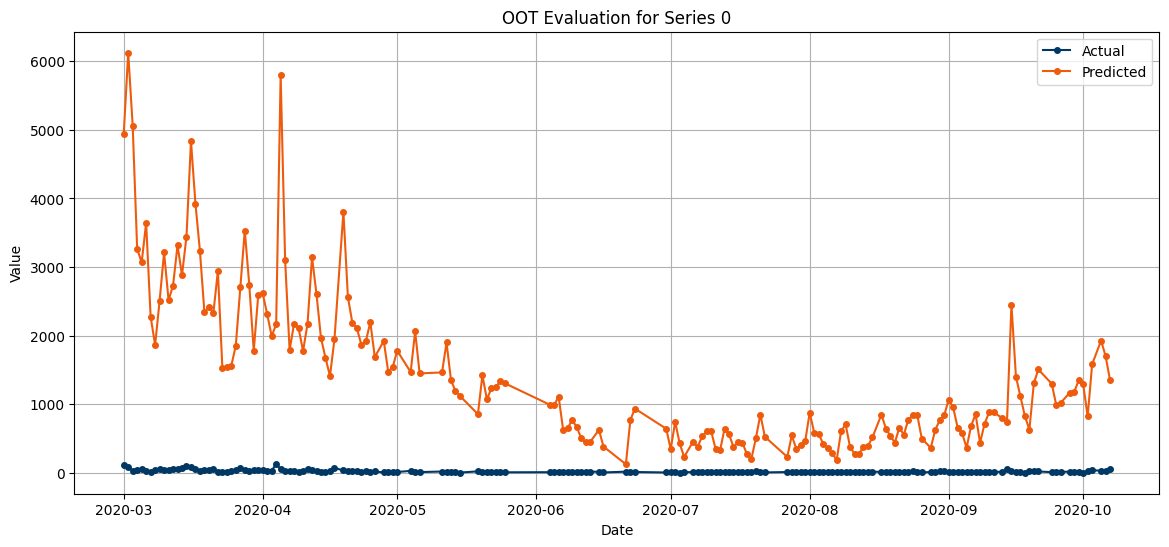

Processing series: 1


c:\Users\77019\pyver\py312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


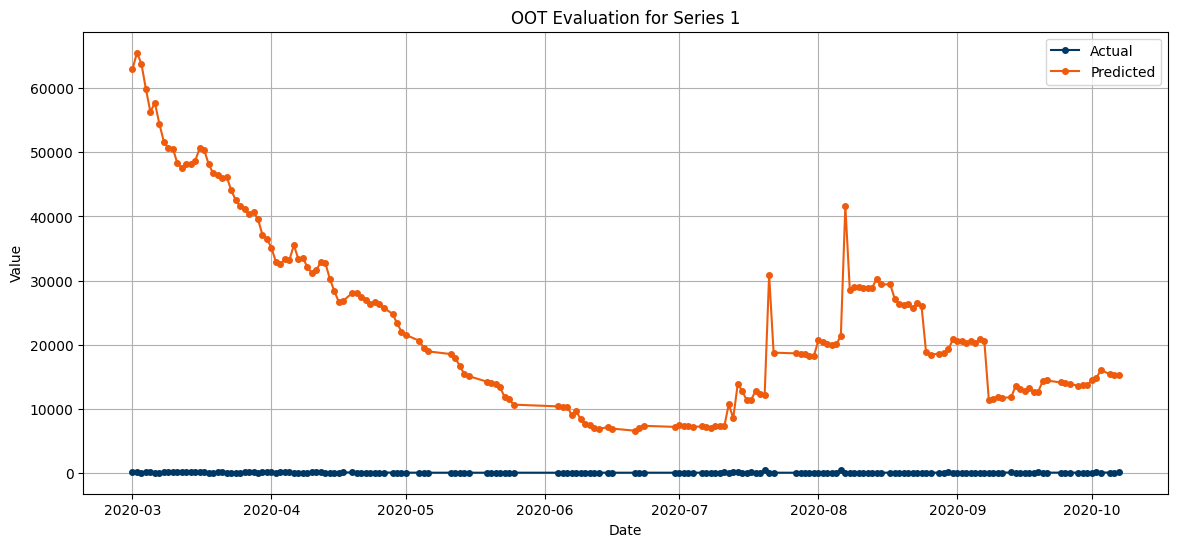

Processing series: 2


KeyboardInterrupt: 

In [100]:
feature_creation_pipeline = Pipeline([
    ("datetime_features", DateTimeFeatureEngineer(country='KZ')),
    ("lag_rolling", LagRollingFeatureEngineer(
        lags=[1,7, 30, 60, 90, 120, 150, 180, 250, 300, 365], 
        windows=[3,7, 15, 30, 50, 70, 90, 120])
        ),
])

models, metrics_df = train_and_evaluate_with_oot(clusters_df, clusters_df.columns[1:], feature_creation_pipeline, train_cutoff="2020-03-01", num_random_tries=3000)

# Print best metrics
print("Best Metrics for Each Series:")
print(metrics_df.sort_values(by="MSE").head())

In [41]:
all_feature_cols = list(df_features.columns)
all_feature_cols.remove('value')       # remove target
if 'date_time' in all_feature_cols:
    all_feature_cols.remove('date_time')  # often we drop date_time for modeling


In [45]:
df_features_train = df_features[df_features.date_time < "2020-03-01"]
df_features_oot = df_features[df_features.date_time >= "2020-03-01"]

In [ ]:
import random

num_random_tries = 3000
results = []

for i in range(num_random_tries):
    # Randomly choose size
    size = random.randint(3, 8)  # pick 3-8 features
    # Randomly sample "size" features
    # chosen = random.sample(reduced_feature_cols, size)
    chosen = random.sample(all_feature_cols, size)
    
    scores = evaluate_subset(chosen, df_features_train, do_scale=True)
    
    res = {
        'try': i+1,
        'chosen_features': chosen,
        'MSE':  scores['MSE'],
        'RMSE': scores['RMSE'],
        'MAE':  scores['MAE'],
        'MAPE': scores['MAPE'],
        'N_rows_used': scores['N']
    }
    results.append(res)

results_df = pd.DataFrame(results)
results_df


In [32]:
# Pick the row with the lowest MSE
best_idx = results_df['MSE'].idxmin()
best_features = results_df.loc[best_idx, 'chosen_features']

print("Best trial index:", best_idx)
print("Best features:", best_features)
print("Corresponding MSE:", results_df.loc[best_idx, 'MSE'])


Best trial index: 1136
Best features: ['value_lag1', 'value_roll3_mean', 'is_holiday', 'day_of_week', 'value_lag120']
Corresponding MSE: 387.299015439944


In [33]:
results_df.loc[best_idx]

try                                                             1137
chosen_features    [value_lag1, value_roll3_mean, is_holiday, day...
MSE                                                       387.299015
RMSE                                                       18.931873
MAE                                                         13.42961
MAPE                                                       32.363016
N_rows_used                                                      950
Name: 1136, dtype: object

In [34]:
# 1) Subset the columns + target in df_features
needed_cols = best_features + ['value', 'date_time']  # so we can plot vs date_time
df_sub = df_features_train[needed_cols].copy()

# 2) Drop rows that have NaN in those columns
df_sub.dropna(subset=best_features + ['value'], inplace=True)
df_sub.sort_values('date_time', inplace=True)
df_sub.reset_index(drop=True, inplace=True)

# Separate X, y
X_final = df_sub[best_features]
y_final = df_sub['value']

# 3) Optionally scale, then train
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

model = LinearRegression()
model.fit(X_scaled, y_final)

# 4) Predict on the same data (or you could do a final hold-out if you want)
y_pred = model.predict(X_scaled)


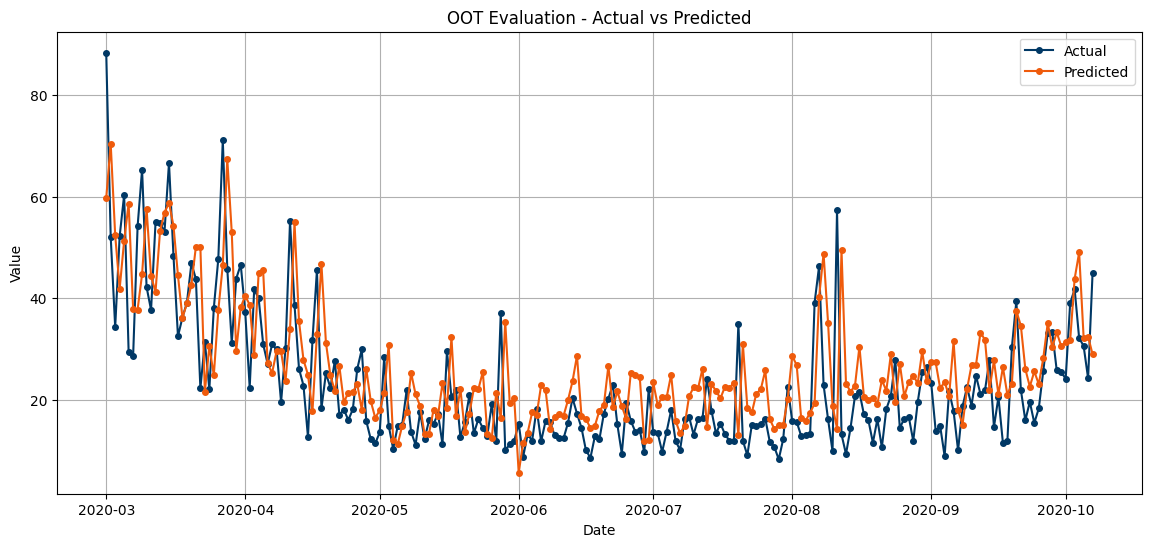

OOT Evaluation Metrics:
{'MSE': 117.61434833456812, 'RMSE': 10.845014907069888, 'MAE': 8.521925165230138, 'MAPE': 44.47843200816712}


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error



# Example Usage
# Assuming you have a trained model, OOT set, and optional scaler
oot_features = df_features_oot[best_features]  # Features from OOT set
oot_target = df_features_oot['value']  # Target column from OOT set
oot_dates = df_features_oot['date_time']  # Date column (optional)

metrics = evaluate_on_oot_with_plot(
    model,
    oot_features,
    oot_target,
    scaler=scaler,
    date_col=oot_dates,
    title="OOT Evaluation - Actual vs Predicted"
)

print("OOT Evaluation Metrics:")
print(metrics)
